# Week 8 - Decision Trees

### Aims

By the end of this notebook you will be able to understand 

>* The Basics of Decision Trees
>* Gini Impurity
>* Classification Trees
>* Ensemble Models and Majority Voting


1. [Setup](#setup)

2. [Basics of Decision Trees](#DecTree)

3. [Gini Impurity](#gini)

4. [Ensemble Models](#majVot)

5. [Breast Cancer Data for Binary Example](#cancer)

In this WS we will be exploring the basics of decision trees . 

- Tree-based methods stratify or segment the predictor space into a number of simple regions1.
- As the spliting rules to make these decision regions can be summerised in a tree structure, these approaches are called decision trees.
- A decision tree can be thought of as breaking data down by asking a series of questions in order to categorise samples into the same class

NOTE THAT, for the simplicity we did not use any data partitioning in below for toy data examples. But for the real data sets, we have the data splitting procedure as a general procedure (Breast cancer data example). 

## Reminder on Terminology

- **Root node**: no incoming edge, zero, or more outgoing edges.

- **Internal node**: one incoming edge, two (or more) outgoing edges.

- **Leaf node**: each leaf node is assigned a class label if nodes are pure; otherwise, the class label is determined by majority vote.

- **Parent and child nodes**: If a node is split, we refer to that given node as the parent node, and the resulting nodes are called child nodes.

- Leaves are typically drawn upside down, so they are at the bottom of the tree. 

One funny example given below (not a big fan of whiskies though) having different number of child nodes at the bottom (not binary all the time). Notice that in our calculations generally we will face with binary cases (In this setting binary means nodes always have two children)


<div>
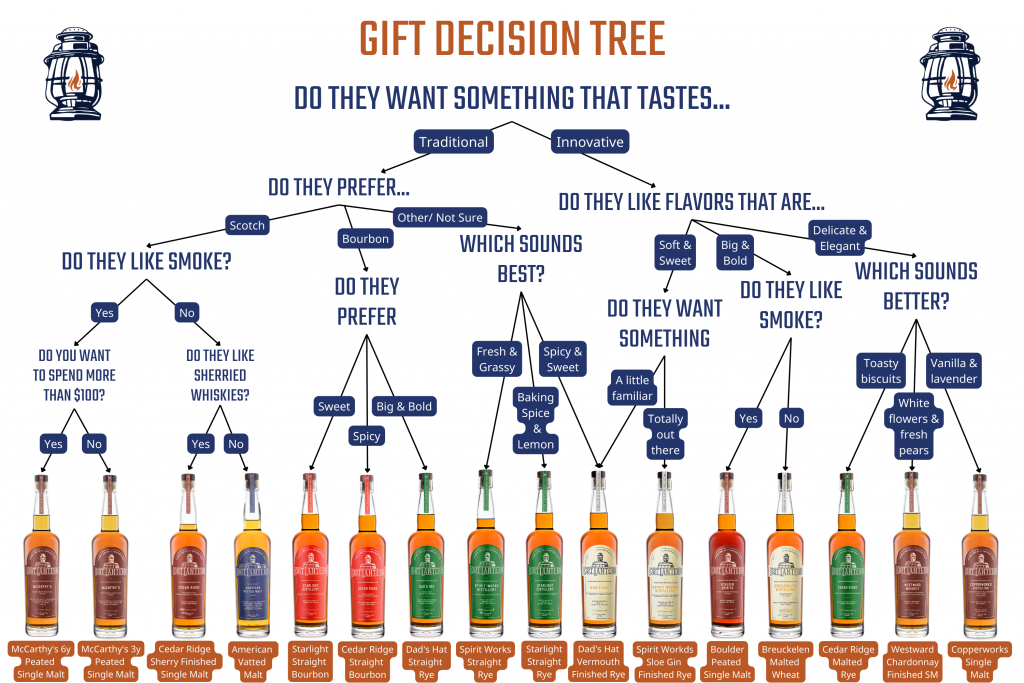
</div>

## CART

Scikit-Learn uses an optimised version of the Classification And Regression Tree (CART) algorithm.

- Splitting Criterion: Information gain
- Number of Splits: Binary
- Independent Variables (Features): Continuous
- Dependent variable: Continuous or Categorical
- Pruning: Pre- & Post-pruning

**Notes**

"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now." https://scikit-learn.org/stable/modules/tree.html

## Information Gain

An algorithm starts at a tree root and then splits the data based on the feature $f$, that gives the largest information gain, $IG$

- To split using information gain relies on calculating the difference between an impurity measure of a parent node, $D_p$, and the impurities of its child nodes, $D_j$; information gain being high when the sum of the impurity of the child nodes is low.

- It is possible to maximise the information gain at each split using, $$IG(D_p, f) = I(D_p) - \sum_{i=1}^{m} \frac{N_j}{N_p} I(D_j)$$ where $I$ is the related impurity measure, $N_p$ is the total number of samples at the parent node and $N_j$ is the number of samples in the j'th child node.

Some algorithms, such as Scikit-learn's implimentation of CART, reduce the potential search space by implimenting binary trees:

- $IG(D_p, f) = I(D_p) - ( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$

- So to maximize the information gain, minimize the expression given in paranthesis $( \frac{N_{left}}{N_p} I(D_{left}) + \frac{N_{right}}{N_p} I(D_{right}) )$

**NOTES**

- The CART algorithm is greedy - meaning it searches for the optimum split at each level. It does not check if this is the best split to improve impurity further down the tree.
- To find the optimal tree is known as an NP-Complete problem, meaning it is intractable even for small training sets
- Two impurity measures that are commonly used in binary decision trees are the gini impurity and entropy (log-loss) 

# 1. General Setup <a id='setup'></a>

## 1.1 Packages

Now lets load in the packages you wil need for this workshop.


In [ ]:
# Display plots inline
%matplotlib inline  

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# sklearn modules list that might be useful, maybe you do not need to use all of them
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data
import warnings # prevent warnings
import joblib # saving models
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.stats.distributions import uniform, loguniform
import itertools
from sklearn.model_selection import GridSearchCV, KFold
#  from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# About Tree models
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from re import search
import matplotlib as mpl

# For Breast cancer data 
from sklearn.datasets import load_breast_cancer

In [ ]:
# Plotting defaults MIGHT BE modified
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.markersize'] = 7.5

##  1.2 Palmer Data Set

In [ ]:
# Install the data set
!pip install palmerpenguins

# Palmer Penguins Data
from palmerpenguins import load_penguins

# 2. PalmerPenguins Data <a id='DecTree'></a>

The "palmer penguins" dataset contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.

In [ ]:
penguins = sns.load_dataset("penguins")
display(penguins.head())

Since there are some missing values, they should be removed first

In [ ]:
# dropna values
penguins_rm = penguins.dropna()
display(penguins_rm.head())

In [ ]:
penguins_rm.info()

In [ ]:
# Look at the summary of continuos variable
penguins_rm.describe().round(2)

### 🚩 Exercise 1 (CORE)

Based on the given plot below, 

- Which species is easy to separate by looking at the plot ?
- Which set of features might be the good choices to use for a classification problem ?


In [ ]:
# Plotting the data set
sns.pairplot(data = penguins_rm, hue = "species")

### 🚩 Exercise 2  (CORE)

Consider the following decision tree fit on the penguins data, based on the selected predictors and try to answer the followings;

- What is the meaning of **max_depth** in the given code snippet ?

- Identify the predictor selected in the top/root node

- State the **type of nodes** illustrated below

- What is the meaning of the numbers inside of Value for each node ?

In [ ]:
# Some selection on data
X = penguins_rm.drop(["island", "sex", "species", "body_mass_g"], axis=1)
y = penguins_rm.species 

In [ ]:
# Fitting DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)

# You can visualize the trained Decision Tree
from sklearn.tree import export_graphviz

tree_data = export_graphviz(
 tree_clf,
 rounded = True, filled = True
 )

# For plotting simply
import graphviz 
graph = graphviz.Source(tree_data) 
graph

---

**!!! Add your comments about the answer here !!!**

### 🚩 Exercise 3  (CORE) <a id='gini'></a>

Related to the information gain calculation, we have Gini or entropy impurity

- Work out on the calculations of the related Gini index values in the leaf nodes for the given output

- What about the corresponding Entropy (log-loss) values for the leaf nodes instead of Gini index values ?

**RECALL**

- **Gini Index**: It is a measure of total variance across the $K$ classes, defined as follows:

$$G = \sum_{k=1}^{K} \widehat{p}_{mk} (1 - \widehat{p}_{mk}) = 
1 - \sum_{k=1}^{K} \widehat{p}_{mk}^2$$ where $\widehat{p}_{mk}$ is the proportion of training observations in the $m$'th region (belong to $mth$ node) coming from the $k$'th class.

- **Entropy**: It is an alternative to Gini Index and defined as; 

$$D = - \sum_{k=1}^{K} \widehat{p}_{mk} \log \widehat{p}_{mk}$$
where the range of $\widehat{p}_{mk}$ guarantees that $0 \leq - \widehat{p}_{mk} \log \widehat{p}_{mk}$.

### 🚩 Exercise 4 (CORE)

- Update the above code snippet by changing the criterion from **Gini** to **Entropy** in the main function and get the similar output

- Compare your results with your own calculations. Do they match exactly or not ?

### 🚩 Exercise 5  (CORE)

What is the accuracy of the fitted decision tree above over the 5-fold CV? 

<details><summary><b><u>Hint</b></u></summary>
    
- You can use simply the function of  `cross_val_score`
    
</details>



In [ ]:
from sklearn.model_selection import cross_val_score

---

**!!! Add your comments about the answer here !!!**


### 🚩 Exercise 6 (CORE)

- Create a new data set including only the Gentoo and Adelie species (changing the problem from multi class to binary class)

- Convert the specias names into numerical class labels

- Consider the `flipper_length_mm` and  `bill_length_mm` as two predictors to create a decision tree on this data set. Basically fit a decision trees and create a diagram similar to the previous exercise again using the same `max_depth` input argument


---

**!!! Add your comments about the answer here !!!**

### 🚩 Exercise 7 (CORE)

Play around some of the input arguments, such as

- `min_samples_split`

- `min_samples_leaf`

- `max_leaf_nodes`

- `min_impurity_decrease`

by changing their values (rather than only `max_depth`) 

- Rerun different models with such selections and compare their performance simply

# 3. Ensemble I: Bagging  <a id='majVot'></a> 

A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. To apply bagging to decision trees, we simply construct 
(i) decision trees using bootstrapped training sets,
(ii) take a majority vote of the resulting predictions.

- A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

- Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

- Specifically, bagging is when sampling is produced with replacement, and without replacement being called pasting

- Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory

- Both bagging and pasting allow training to be sampled several times across multiple predictors, with bagging only allowing several samples for the same predictor

- Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers

- Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

<div>
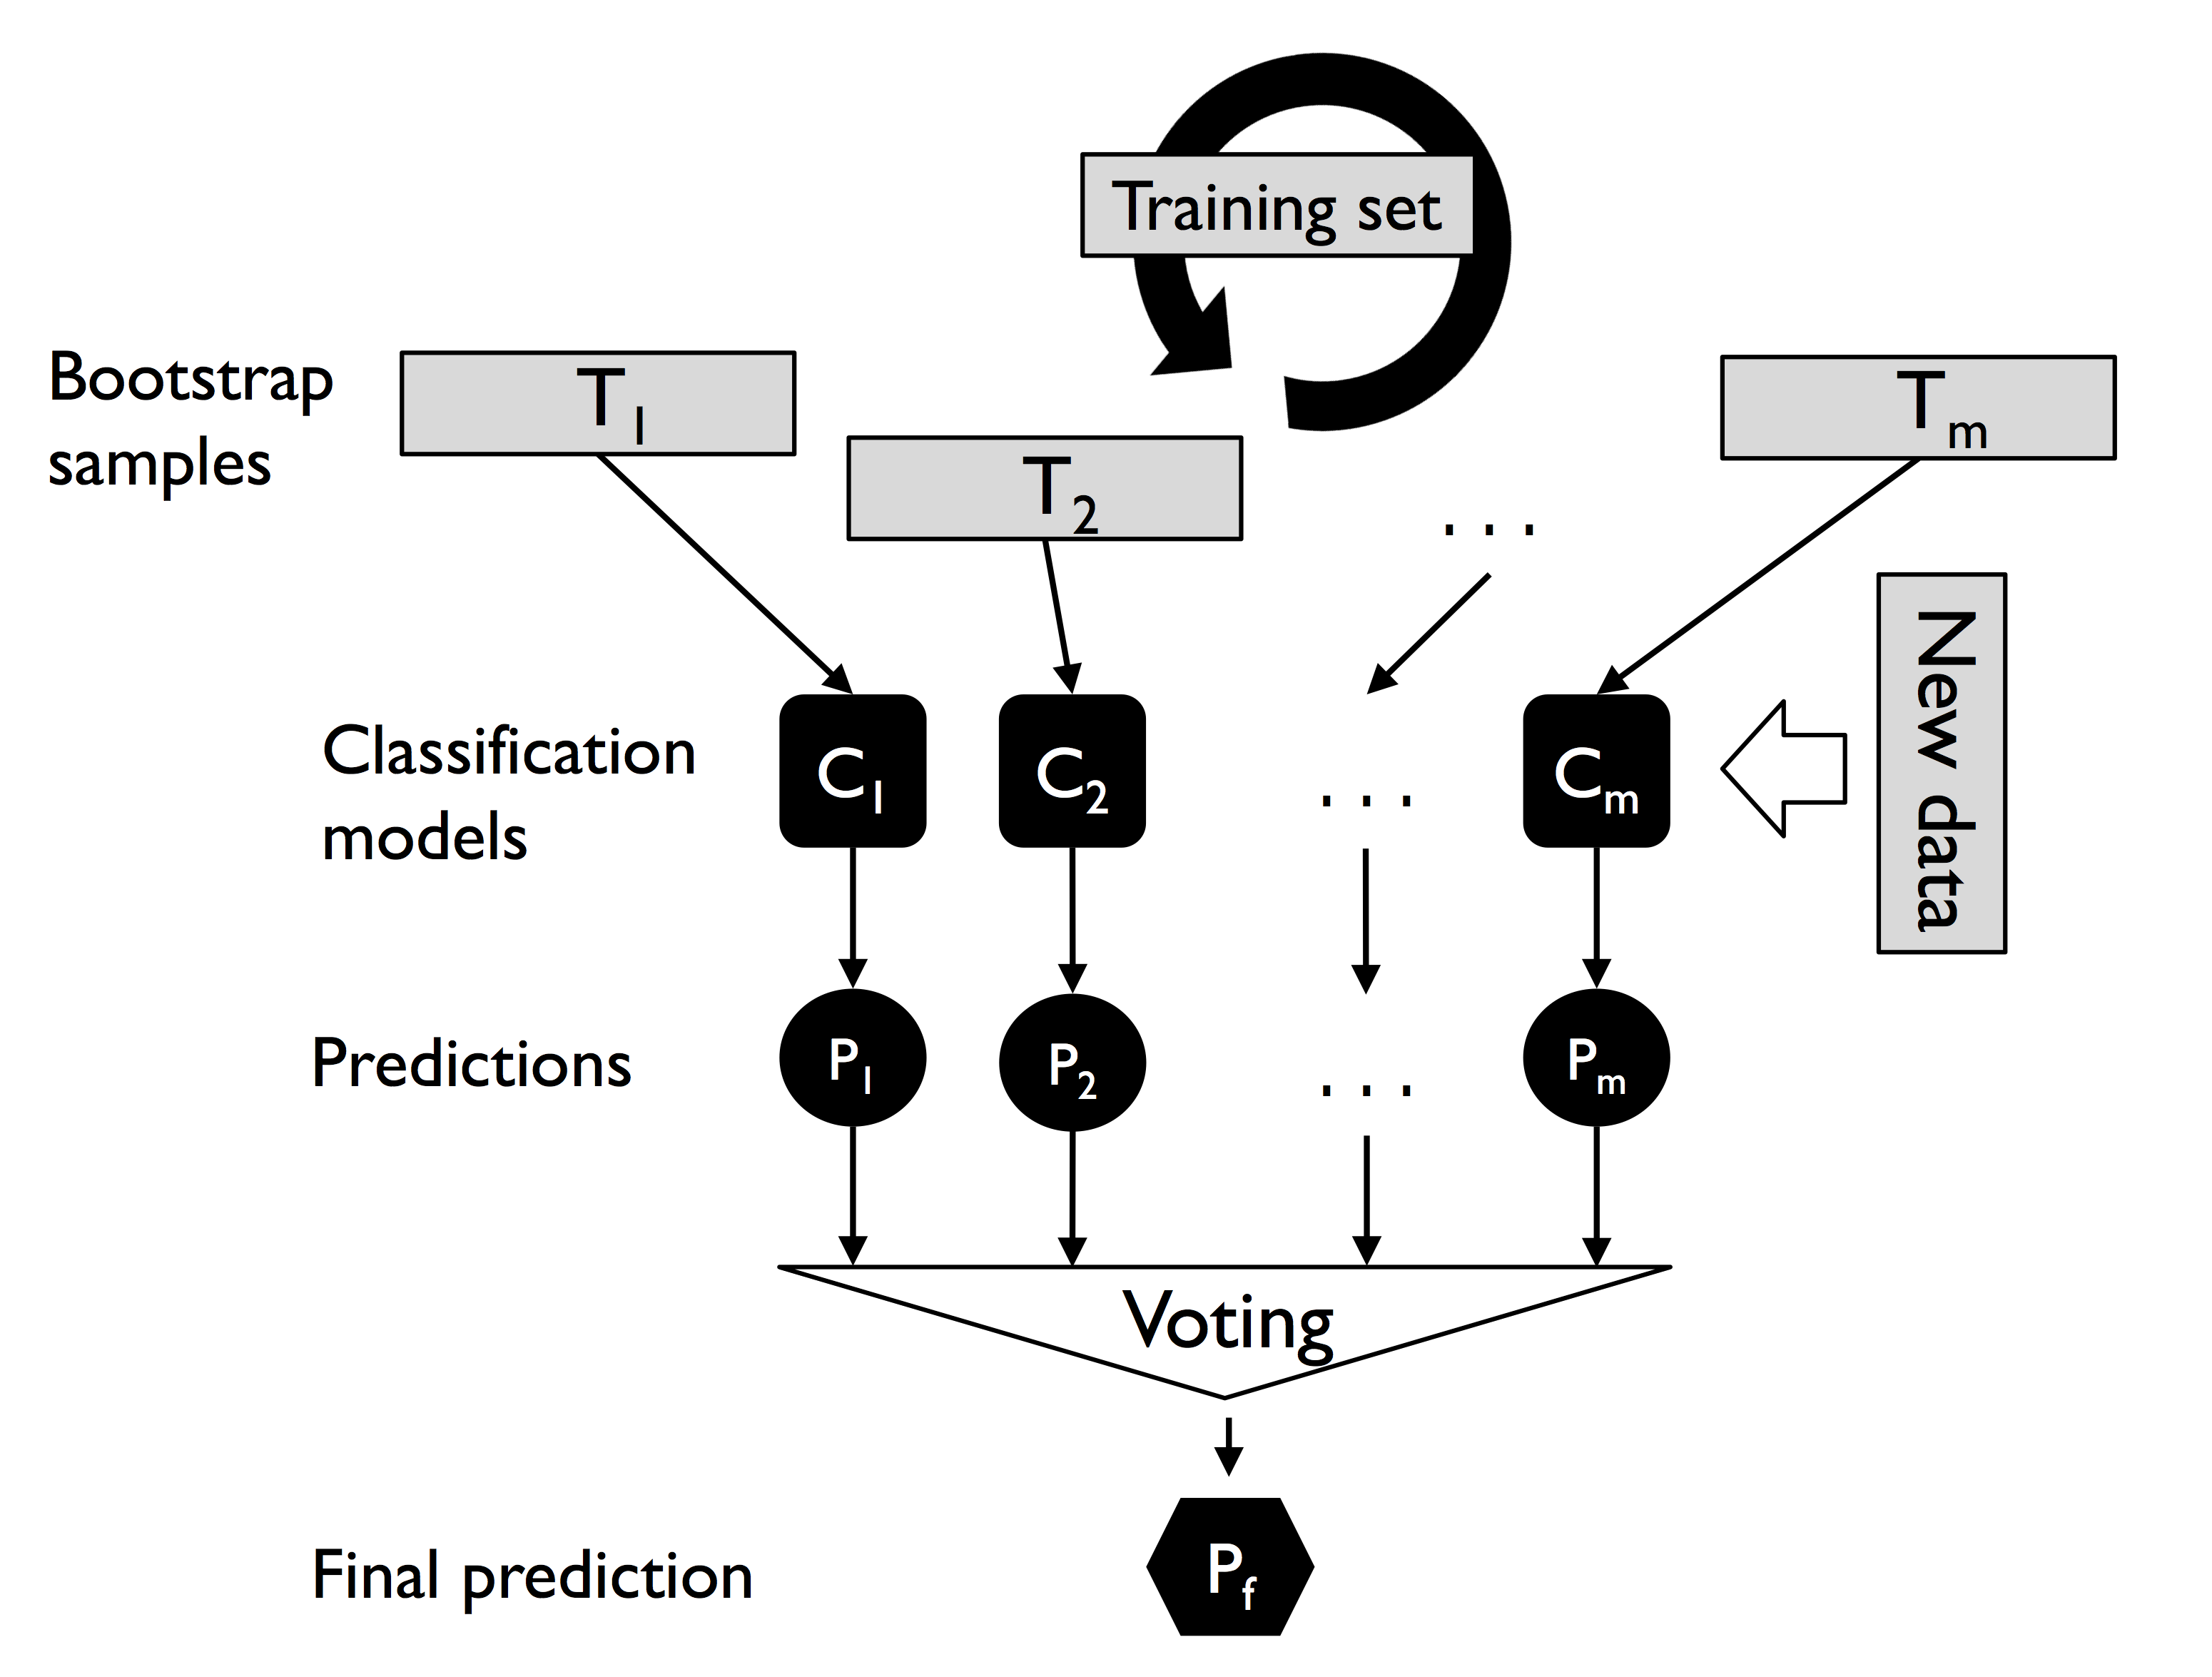
</div>


For some details on sklearn, please see that webpage 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html




### 🚩 Exercise 8  (CORE)

Execute the following code and try to answer the followings:

- What is the predicted class labels based on given Bagging model, using the same predictors that we used in Exercise 2

- How do you predict a new data having  (bill_length_mm, bill_depth_mm,	flipper_length_mm) = (15.6, 34.7, 185.4) ? 

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10, random_state=42).fit(X, y)

---

### 🚩 Exercise 9  (CORE)

Based on the above fitted model,

1. Calculate the out-of-bag score

2. Examine the impact of `n_estimators` by using different values in $(100, 1000, 10000)$

3. Compare all the out-of-bag scores of all fitted models under different `n_estimators` values

## 4. Ensemble II: RandomForest

Random forests are among the most widely used machine learning algorithm. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. The random forest algorithm can therefore be summarized in four steps;

- Draw a random bootstrap sample of size $n$

- Grow a decision tree from the bootstrap sample. At each node:
    * Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
    * Split the node using the feature that provides the best split according to the objective function.

- Repeat the steps above $k$ times.

- Aggregate the prediction by each tree to assign the class label by majority vote.


**NOTES** 

- The sub-sample size is controlled with the `max_samples` parameter if `bootstrap=True` (default), otherwise the whole dataset is used to build each tree.

- Random forests fit decision trees on different bootstrap samples, and for each decision tree, select a random subset of features at each node to decide upon the optimal split. The feature subset to consider at each node is a hyperparameter that we can tune

- Instead of using majority vote, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.

- Notice that if a random forest is built using all features, then this is simply bagging.

- you can also bootstrap features in the `BaggingClassifier` using `bootstrap_features=True`

- By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other.

- If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities

### Related Hyperparameters

Important parameters to adjust are;

- `n_estimators`: Larger is generally better as averaging more trees will typically yield a more robust ensemble by reducing overfitting.
- `max_features`: Determines how random each tree is so smaller number of features at each split reduces overfitting.
- `max_samples`: Sample size of the bootstrap sample, also reduces overfitting. pre-pruning options (`max_depth`, `max_leaf_nodes`): more important for single trees, but can improve performance, reduce space, and time requirements.

**NOTES**

- Typically you want to use as many estimators as you have time and memory for training.

- A good rule of thumb for `max_features` default values are `max_features=sqrt(n_features)` for classification and `max_features=n_features` for regression

- "Segal (2004) showed that if your data has many noisy predictors and higher `[max_features]` values are performing best, then performance may improve by increasing node size (i.e., decreasing tree depth and complexity). Moreover, if computation time is a concern then you can often decrease run time substantially by increasing the node size and have only marginal impacts to your error estimate..."

- Small bootstrap samples do tend to produce worse models

For a more thorough discussion of forest hyperparameters, see: Probst, Philipp, Bernd Bischl, and Anne-Laure Boulesteix. 2018. “Tunability: Importance of Hyperparameters of Machine Learning Algorithms.” arXiv Preprint arXiv:1802.09596.

### 🚩 Exercise 10 (CORE)

Consider the above problem under randomforest approach simply using the `RandomForestClassifier()` function adjusting the **max_depth** value

In [ ]:
from sklearn.ensemble import RandomForestClassifier

---
 
### 🚩 Exercise 11 (CORE)

Set up a function for experimenting with different n_estimators and max_depth. For this purpose, consider, 

1. **n_estimators** in $[1,10,100, 1000]$
2. **max_depth** in $[2, 3, 4]$

Find the final out-of-bag score based on the optimal one based on your comparison on the accuracy

---

### 🚩 Exercise 12  (EXTRA)

Based on the above fitted models

1. Do you prefer bagging or randomforest ? What can you say about any preference over the limited findings that we get ?


**!!! Add your comments about the model performance here !!!**


# 5 Voting Classifier

Majority voting can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes). Majority vote refers to binary class decisions but can be generalized to a multi-class setting using plurality voting

In majority voting, the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier. Simply

E.g., if the prediction for a given sample is

- classifier 1 -> class 1

- classifier 2 -> class 1

- classifier 3 -> class 2

the VotingClassifier (with voting='hard' by default) would classify the sample as “class 1” based on the majority class label.

<div>
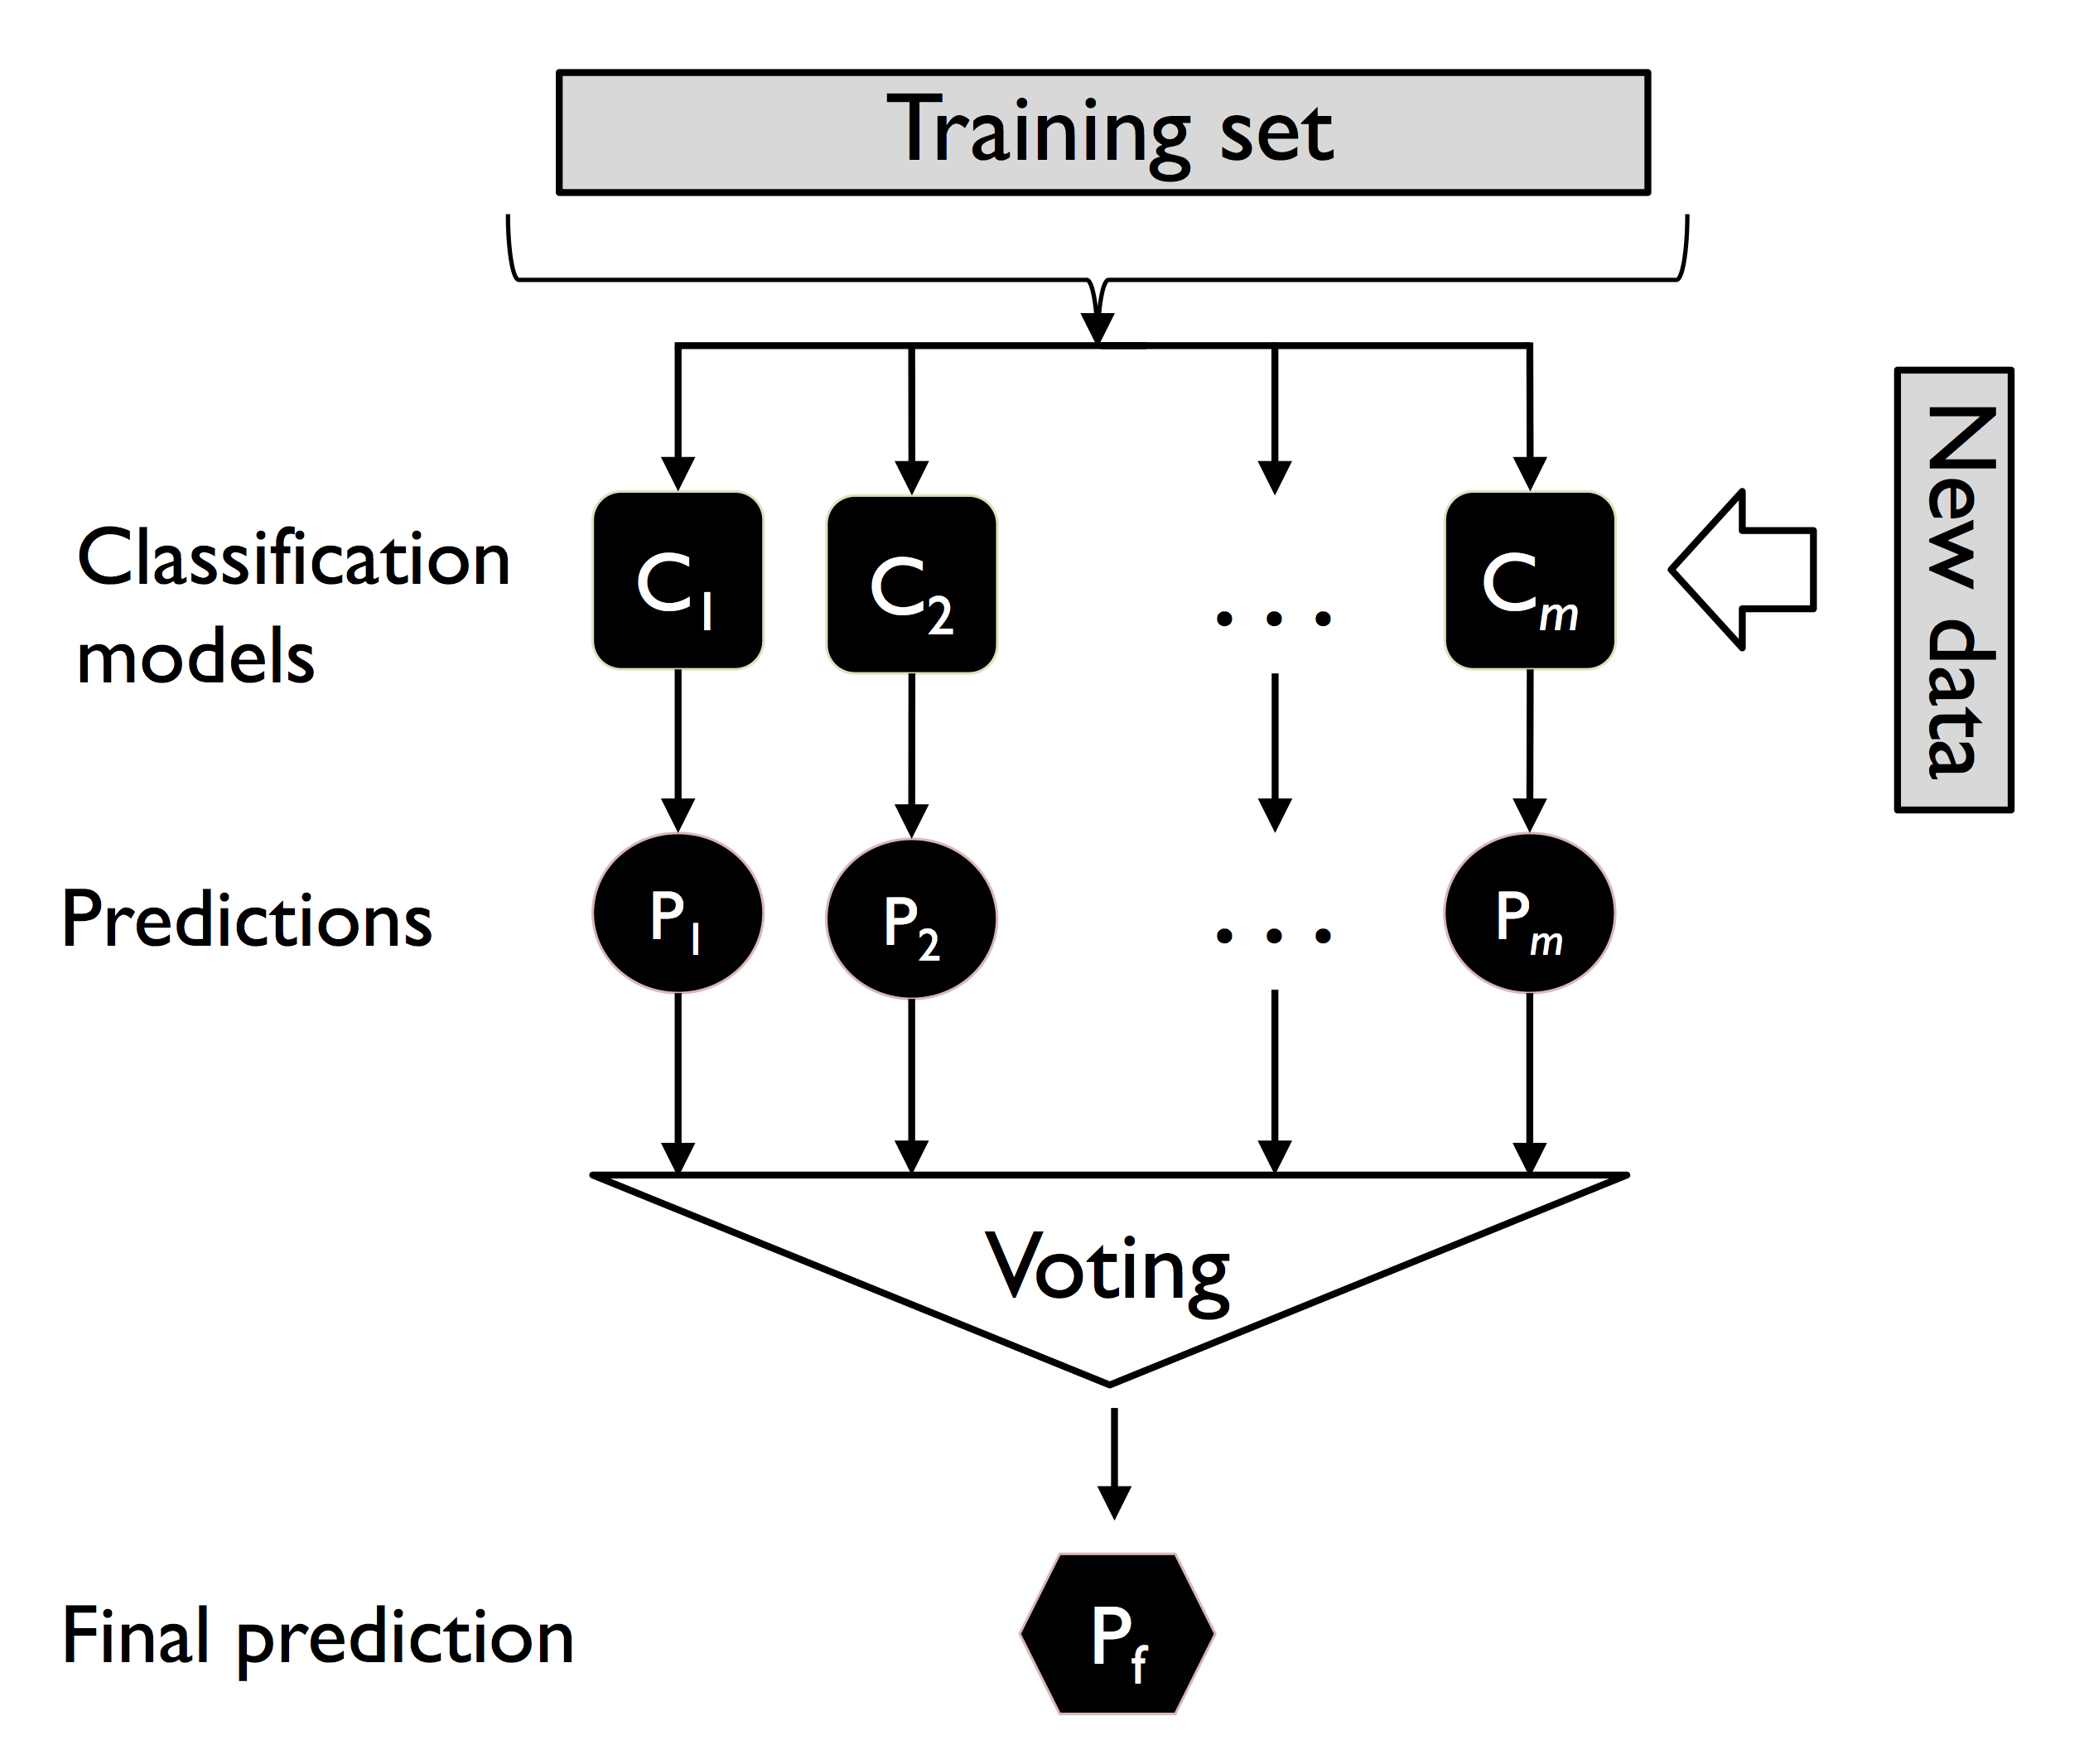
</div>


**NOTES**

- Scikit-learn uses the `predict_proba` method to compute class probabilities.

- "In decision trees, the probabilities are calculated from a frequency vector that is created for each node at training time. The vector collects the frequency values of each class label computed from the class label distribution at that node. Then, the frequencies are normalized so that they sum up to 1... Although the normalised probabilities returned by both the decision tree and k-nearest neighbors classifier may look similar to the probabilities obtained from a logistic regression model, we have to be aware these are actually not derrived from probability mass functions."

For further details, please see the documentation from here: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

---

### 🚩 Exercise 13  (EXTRA)

- Complete the following code snippet with your RandomForest and Bagging model selection above

- Look at the accuracy score of the each model and voting classifier one, is there any improvement with voting classifier or not ?


In [ ]:
# As an example for different models 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Your bagging model
bag_clf = 

# Your random forest model
rnd_clf = 

# Default SVC model
svm_clf = SVC()

voting_clf = VotingClassifier(
 estimators=[('bag', bag_clf), ('rf', rnd_clf), ('svc', svm_clf)],
 voting='hard')

voting_clf.fit(X, y)

# 6 Breast Cancer Data Case (EXTRA) <a id='cancer'></a>

Load and return the breast cancer wisconsin dataset (classification). The breast cancer dataset is a classic and very easy binary classification dataset since we have two cancer types, WDBC-Malignant and WDBC-Benign.

You can find other details about the data set from here: https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset




In [ ]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

---

### 🚩 Exercise 14 (EXTRA)

1. Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $30\%$ of the whole sample

2. Consider a `DecisionTree classifier` on the training data set using all features

3. Compute the pruning path during `Minimal Cost-Complexity Pruning`. Examine and explain your findings

<details><summary><b><u>Hint</b></u></summary>
    
- You can use simply the function of  `cost_complexity_pruning_path`
    
- See further details from here: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
    
</details> 

### 🚩 Exercise 15 (EXTRA)

Inside of pruning path during (in the output of `cost_complexity_pruning_path`), we have different applicable alpha values and corresponding impurity in the leaf nodes introduced. This contains two Numpy Arrays of alpha and impurities in general. Using the obtained values, 

- Simply plot that relationship based on alpha and corresponding impurity values

- Find an optimal value of alpha by using the model accuracy

---

### 🚩 Exercise 16 (EXTRA)

Explore the following code snippet, about the fitted model and relevant visualization. Just an illustration from the previous course materials including some helper functions. 

In [ ]:
display(X.info())

In [ ]:
# About visualization of regions and trees together
# NOT obligatory

# install mlxtend first if you got an error
!pip install mlxtend

from mlxtend.plotting import plot_decision_regions

# A new function for creating the regions over the feature space as well
def regions_tree(DT, X, y, feature_names, class_names, col_dict, l_label_pos=None, 
                 r_label_pos=None, tp_label_pos=None, impurity = False, 
                 xaxis_lim = None, yaxis_lim = None, color=False, title=None, 
                 savefig=None, alpha=1):
    DT.fit(X,y)

    fig, axes = plt.subplots(ncols=2, figsize = (width_inch*2, height_inch))
    plt.sca(axes[0])

    scatter_kwargs = {'alpha': alpha}
    ax = plot_decision_regions(X, y, clf = DT,
                               markers = ','.join([shape_dict[x] for x in class_names]),
                               colors = ','.join([col_dict[x] for x in class_names]),
                               scatter_kwargs = scatter_kwargs
                              )

    handles, labels = ax.get_legend_handles_labels()
    
    if l_label_pos:
        plt.text(l_label_pos[0][0], l_label_pos[0][1], "$R_1$", bbox=dict(facecolor='white', alpha=0.3))
        plt.text(l_label_pos[1][0], l_label_pos[1][1], "$R_2$", bbox=dict(facecolor='white', alpha=0.3))
    
    ax.legend(handles, 
              class_names, 
              framealpha=0.3, scatterpoints=1)

    plt.xlabel(feature_names[0]) 
    plt.ylabel(feature_names[1])
    if xaxis_lim:
        plt.xlim(xaxis_lim)
    if yaxis_lim:
        plt.ylim(yaxis_lim)
    
    # The arrows dont show up on versions of Scikit Learn due to a weird interaction with sns 
    # so I need to use `plt.style.context("classic")`.
    with plt.style.context("classic"):
        plt.sca(axes[1])
        tp = tree.plot_tree(DT,
                       feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)
        if r_label_pos:
            axes[1].text(r_label_pos[0][0], r_label_pos[0][1],
                         "$R_1$")
            axes[1].text(r_label_pos[1][0], r_label_pos[1][1], 
                         "$R_2$")
            
        if tp_label_pos:
            axes[1].text(tp_label_pos[0][0], tp_label_pos[0][1],
                         "True", {'fontweight':'bold'})
            axes[1].text(tp_label_pos[1][0], tp_label_pos[1][1], 
                         "False", {'fontweight':'bold'})
        
        for i, node in enumerate(tp):
            for class_name in class_names:
                if search(class_name, node.get_text()):
                    tp[i].set_backgroundcolor(col_dict[class_name])

    if title:
        plt.suptitle(title)
        
    if savefig:
        plt.savefig(savefig)
    
    return fig

In [ ]:
fig_num=0
plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

col_dict = {
    "benign":"#ff7600",
    "malignant":"#057576"}

shape_dict = {
    "benign":"o",
    "malignant":"X"}

In [ ]:
def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

import urllib
import base64
from io import BytesIO, StringIO

DT_g = DecisionTreeClassifier(criterion='gini',
                               random_state=42)

cancer_features = ['mean radius','mean smoothness']
fig = regions_tree(DT_g, X[cancer_features].values, y.values, cancer_features, 
             load_breast_cancer().target_names, col_dict, yaxis_lim=[0.05,0.20],
             title = "Figure %d: Breast Cancer Overfitting"%fig_num
            )
plt.close()

display(MatplotlibFigure(fig, centered=True))

### 🚩 Exercise 16 (EXTRA)

Consider input arguments of `DecisionTreeClassifier()` function as before and create a pruned tree by setting one of these arguments manually

- Such as, `max_depth = 5` etc.